# Generative Adversarial Network


## Imports

In [2]:
!pip3 install wandb tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.0 MB/s 
     |████████████████████████████████| 1.1 MB 47.1 MB/s 
     |████████████████████████████████| 181 kB 55.4 MB/s 
     |████████████████████████████████| 162 kB 58.7 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 162 kB 59.0 MB/s 
     |████████████████████████████████| 158 kB 76.7 MB/s 
     |████████████████████████████████| 157 kB 67.9 MB/s 
     |████████████████████████████████| 157 kB 65.9 MB/s 
     |████████████████████████████████| 157 kB 78.2 MB/s 
     |████████████████████████████████| 157 kB 60.6 MB/s 
     |████████████████████████████████| 157 kB 59.2 MB/s 
     |████████████████████████████████| 157 kB 63.0 MB/s 
     |████████████████████████████████| 157 kB 53.5 MB/s 
     |████████████████████████████████| 156 kB 71.6 MB/s 
  Created wheel for pathtools: fil

In [3]:
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow import keras
from wandb.keras import WandbCallback

import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import wandb
import math

## Utils

In [4]:
def show_results(model):
    random_latent_vectors = tf.random.normal(shape=(64, model.latent_dim))
    int_reward, generated_images = model(random_latent_vectors, training=False)

    plt.figure(figsize=(16, 24))
    for i in range(generated_images.shape[0]):
        plt.subplot(8, 8, i+1)
        plt.imshow(tf.cast((generated_images[i] * 127.5) + 127.5, tf.uint8))
        plt.title(f"Reward:\n{int_reward[i]}")
        plt.axis('off')
    plt.show()

## Model

In [5]:
class GAN(keras.Model):
    def __init__(self, latent_dim):
        super(GAN, self).__init__()
        self.latent_dim = latent_dim

        # Create the discriminator
        self.discriminator = keras.Sequential(
            [
                keras.Input(shape=(64, 64, 3)),
                keras.layers.GaussianNoise(0.1),

                tfa.layers.SpectralNormalization(keras.layers.Conv2D(64, 3, strides=(1, 1), padding="same")),
                keras.layers.LeakyReLU(alpha=0.2),
                tfa.layers.SpectralNormalization(keras.layers.Conv2D(64, 4, strides=(2, 2), padding="same")),
                keras.layers.LeakyReLU(alpha=0.2),

                tfa.layers.SpectralNormalization(keras.layers.Conv2D(128, 3, strides=(1, 1), padding="same")),
                keras.layers.LeakyReLU(alpha=0.2),
                tfa.layers.SpectralNormalization(keras.layers.Conv2D(128, 4, strides=(2, 2), padding="same")),
                keras.layers.LeakyReLU(alpha=0.2),

                tfa.layers.SpectralNormalization(keras.layers.Conv2D(256, 3, strides=(1, 1), padding="same")),
                keras.layers.LeakyReLU(alpha=0.2),
                tfa.layers.SpectralNormalization(keras.layers.Conv2D(256, 4, strides=(2, 2), padding="same")),
                keras.layers.LeakyReLU(alpha=0.2),

                tfa.layers.SpectralNormalization(keras.layers.Conv2D(512, 4, strides=(2, 2), padding="same")),
                keras.layers.LeakyReLU(alpha=0.2),

                keras.layers.Conv2D(1, 4),
                keras.layers.Flatten()
            ],
            name="discriminator",
        )
        self.generator = keras.Sequential(
            [
                keras.Input(shape=(latent_dim,)),
                keras.layers.Reshape((1, 1, latent_dim)),

                tfa.layers.SpectralNormalization(keras.layers.Conv2DTranspose(512, 4, use_bias=False)),
                tfa.layers.InstanceNormalization(),
                keras.layers.LeakyReLU(alpha=0.2),

                tfa.layers.SpectralNormalization(keras.layers.Conv2DTranspose(256, 4, strides=(2, 2), padding="same", use_bias=False)),
                tfa.layers.InstanceNormalization(),
                keras.layers.LeakyReLU(alpha=0.2),

                tfa.layers.SpectralNormalization(keras.layers.Conv2DTranspose(128, 4, strides=(2, 2), padding="same", use_bias=False)),
                tfa.layers.InstanceNormalization(),
                keras.layers.LeakyReLU(alpha=0.2),

                tfa.layers.SpectralNormalization(keras.layers.Conv2DTranspose(64, 4, strides=(2, 2), padding="same", use_bias=False)),
                tfa.layers.InstanceNormalization(),
                keras.layers.LeakyReLU(alpha=0.2),

                keras.layers.Conv2DTranspose(3, 4, strides=(2, 2), padding="same", activation='tanh'),
            ],
            name="generator",
        )

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def call(self, inputs, training=None):
        generated_images = self.generator(inputs, training=training)
        score = self.discriminator(generated_images, training=training)
        return score, generated_images

    def summary(self):
        self.generator.summary()
        self.discriminator.summary()

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]

        # -------------------- Update 'Discriminator' -------------------- #
        with tf.GradientTape() as tape:
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            fake_output, _ = self(random_latent_vectors, training=True)
            real_output = self.discriminator(real_images, training=True)

            d_loss_real = self.loss_fn(tf.ones_like(real_output), real_output)
            d_loss_fake = self.loss_fn(tf.ones_like(fake_output)*(-1), fake_output)
            d_loss = d_loss_real + d_loss_fake

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # -------------------- Update 'Generator' -------------------- #
        with tf.GradientTape() as tape:
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            fake_output, _ = self(random_latent_vectors, training=True)
            g_loss = - tf.reduce_mean(fake_output)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )

        return {
            "d_loss": d_loss,
            "g_loss": g_loss,
            "real_output": tf.reduce_mean(real_output),
            "fake_output": tf.reduce_mean(fake_output),
        }

## Dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
dataset_loaded = tfds.load('celeb_a', shuffle_files=True, download=True, data_dir='/content/drive/MyDrive/tensorflow_datasets')
dataset = dataset_loaded['train'].concatenate(dataset_loaded['test'])
dataset = dataset.concatenate(dataset_loaded['validation'])

dataset = dataset.map(lambda data: tf.image.resize(data['image'], [64, 64]), num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(lambda img: (tf.cast(img, tf.float32) - 127.5) / 127.5, num_parallel_calls=tf.data.AUTOTUNE)  # Normalize the images to [-1, 1]
dataset = dataset.shuffle(buffer_size=100000, reshuffle_each_iteration=True).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)

## Training

In [ ]:
wandb.init(project="GAN_RL_Reward")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 1, 128)         0         
                                                                 
 spectral_normalization_7 (S  (None, 4, 4, 512)        1048704   
 pectralNormalization)                                           
                                                                 
 instance_normalization (Ins  (None, 4, 4, 512)        1024      
 tanceNormalization)                                             
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 spectral_normalization_8 (S  (None, 8, 8, 256)        2097664   
 pectralNormalization)                                           
                                                         

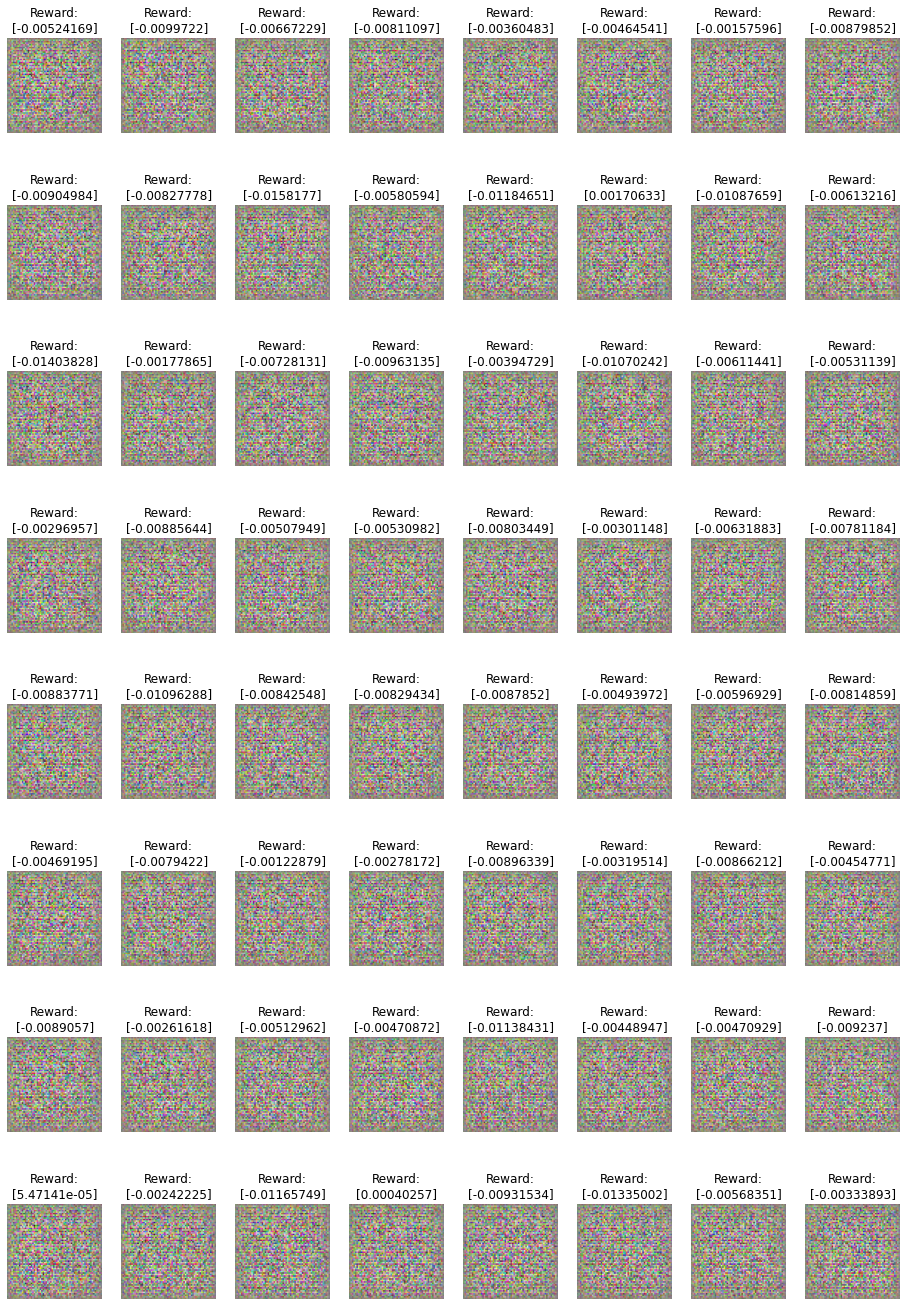

In [ ]:
gan = GAN(latent_dim=128)
gan.compile(
    d_optimizer=keras.optimizers.Adam(
        learning_rate=0.0002,
        beta_1=0.5,
        beta_2=0.999,
    ),
    g_optimizer=keras.optimizers.Adam(
        learning_rate=0.0002,
        beta_1=0.5,
        beta_2=0.999,
    ),
    loss_fn=keras.losses.Hinge(),
)
gan.summary()
show_results(gan)

In [ ]:
gan.fit(
    dataset,
    epochs=50,
    callbacks=[
        WandbCallback(monitor='g_loss', mode='min', save_model=False),
    ],
)

wandb: WARNING Unable to compute FLOPs for this model.


Epoch 1/50
3166/3166 [==============================] - 389s 108ms/step - d_loss: 1.8479 - g_loss: 0.4356 - real_output: -0.0152 - fake_output: -0.4356
Epoch 2/50
3166/3166 [==============================] - 356s 107ms/step - d_loss: 1.7743 - g_loss: 0.6203 - real_output: -0.0608 - fake_output: -0.6203
Epoch 3/50
3166/3166 [==============================] - 356s 107ms/step - d_loss: 1.5977 - g_loss: 0.7743 - real_output: 0.1043 - fake_output: -0.7743
Epoch 4/50
3166/3166 [==============================] - 354s 106ms/step - d_loss: 1.5868 - g_loss: 0.7565 - real_output: 0.1420 - fake_output: -0.7565
Epoch 5/50
3166/3166 [==============================] - 355s 106ms/step - d_loss: 1.5501 - g_loss: 0.7376 - real_output: 0.1952 - fake_output: -0.7376
Epoch 6/50
3166/3166 [==============================] - 354s 106ms/step - d_loss: 1.5383 - g_loss: 0.7263 - real_output: 0.2174 - fake_output: -0.7263
Epoch 7/50
3166/3166 [==============================] - 354s 106ms/step - d_loss: 1.5683 - g

In [ ]:
gan.save_weights("/content/drive/MyDrive/weights_GAN.h5")
wandb.save("/content/drive/MyDrive/weights_GAN.h5")

## Evaluation

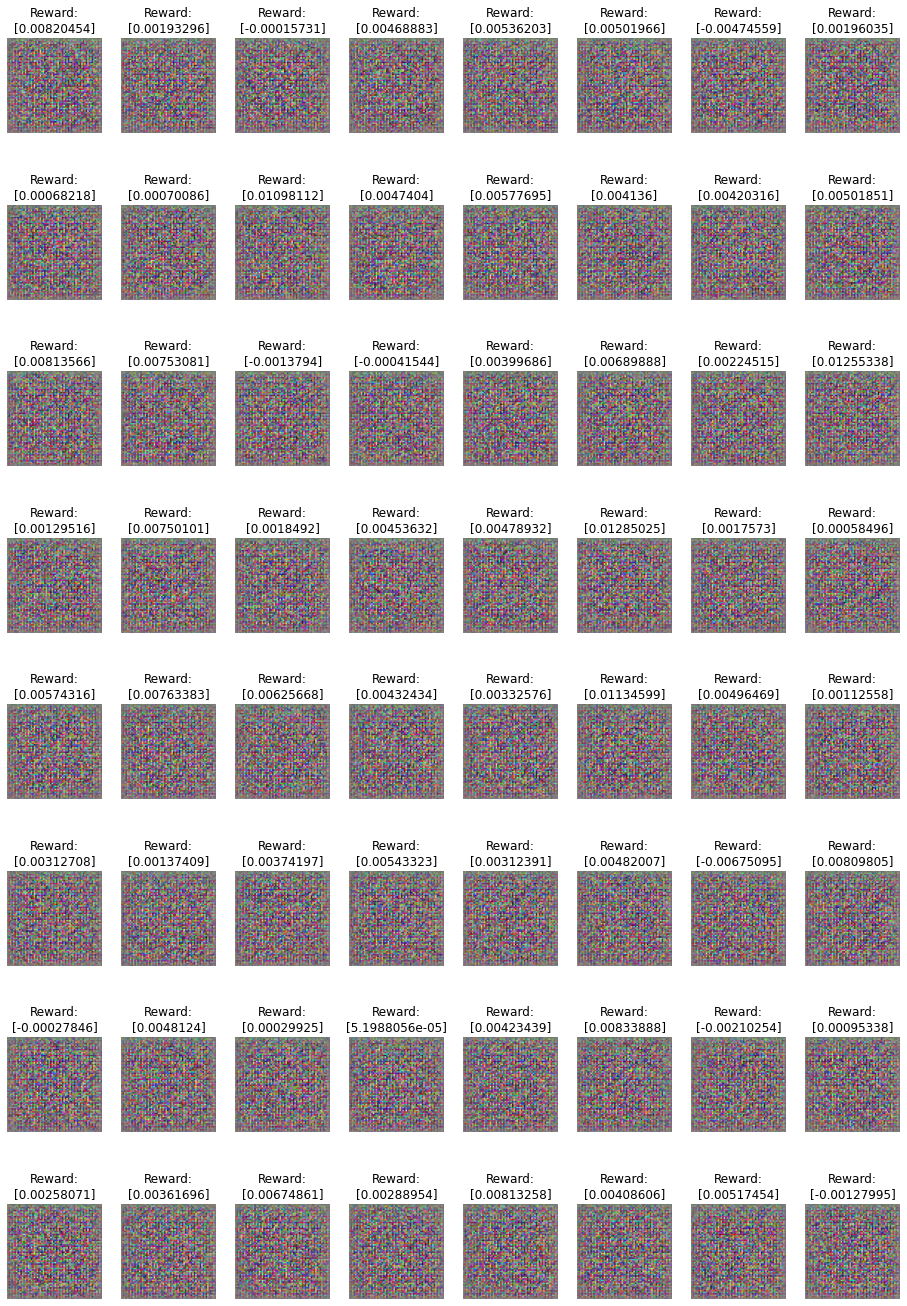

In [10]:
gan = GAN(latent_dim = 128)
show_results(gan)
gan.load_weights("/content/drive/MyDrive/weights_GAN.h5")

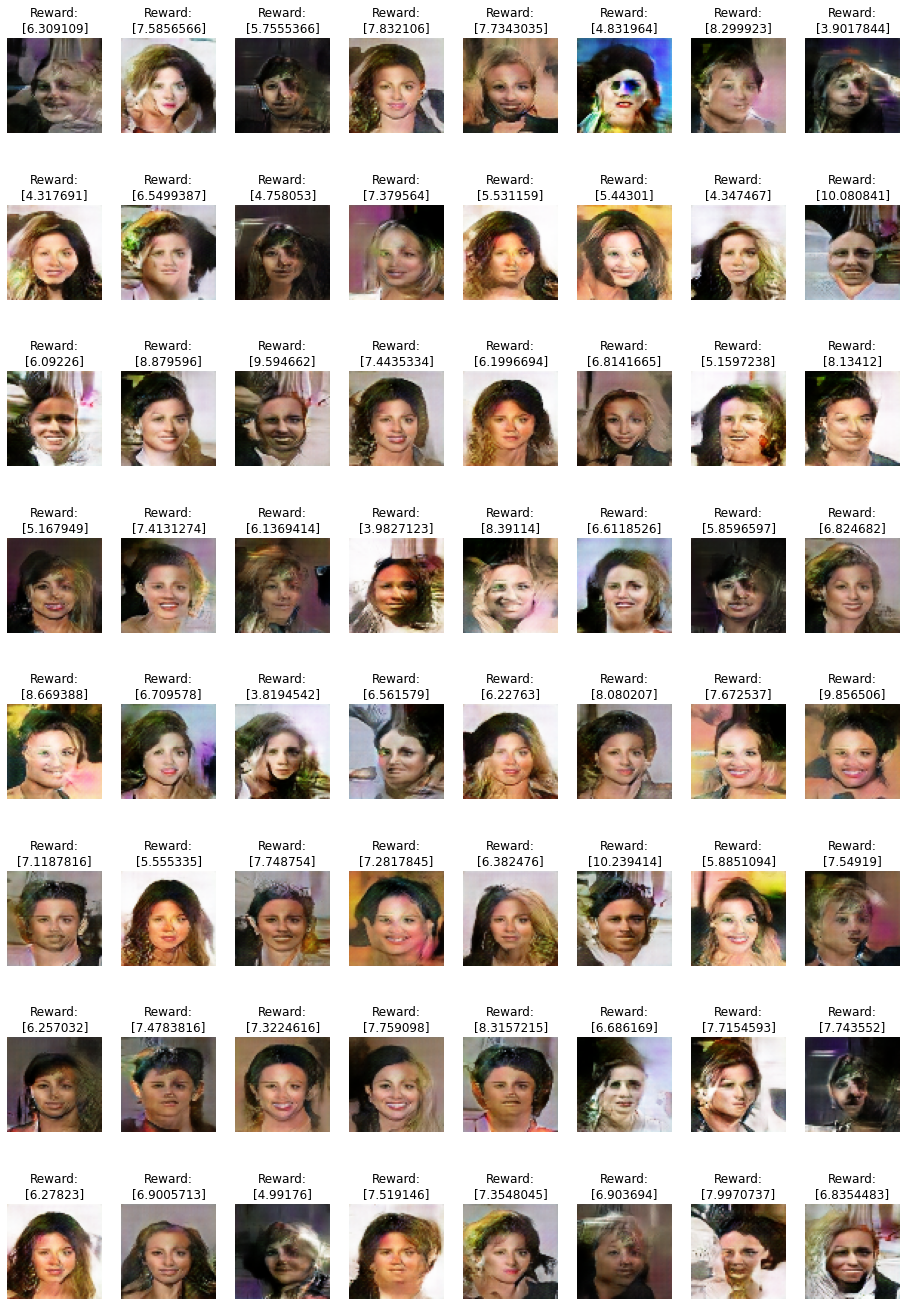

In [20]:
show_results(gan)

In [ ]:
real_image = list(dataset.take(1).as_numpy_iterator())[0]
int_reward = gan.discriminator(real_image[:5], training=False)

plt.figure(figsize=(10, 15))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(tf.cast((real_image[i] * 127.5) + 127.5, tf.uint8))
    plt.title(f"Reward:\n{int_reward[i]}")
    plt.axis('off')
plt.show()